

# Project: Investigating the FBI Gun Dataset

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
    <ul>
        <li><a href="#question1">Research Question1</a></li>
        <li><a href="#question2">Research Question2</a></li>
        <li><a href="#question3">Research Question3</a></li>
    </ul>
<li><a href="#conclusions">Conclusions</a></li>
    <ul>
        <li><a href="#limit">Limitations</a></li>
    </ul>
</ul>

<a id='intro'></a>
# Introduction

> The dataset used in this notebook is the FBI Gun Datasets, which include two dataset, one is a number of background checks from FBI upon any gun purchases, the other one is a Census Data including various census related variables.

> The FBI Gun data inclues a range of different background check types, to name a few, 'permit', 'permit_recheck', 'handgun', 'long_gun', 'multiple'(purchasing more than one gun per background check). For each month, each state, there's a data point consisting all the above mentioned variables. Among all the variables, only the 'totals' variable will be used here, which means the total number of all the various background checks in each state and month.



* Dependent Variable: the 'totals' variable in gun data.
* Independent Variables: all the numerical variable in census dataset

### Questions to answer:

**1. What census data is most associated with high gun registration?**

**2. Is there a correlation between ethnic group proportion and gun registration?**

**3. Is there a seasonal pattern for firearm shopping? **

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline

<a id='wrangling'></a>
# Data Wrangling



### General Properties

In [2]:
# Loading the data and print out the head and performing operations to inspect data

In [3]:
# reading csv format data
df_census = pd.read_csv('./ncis-and-census-data//U.S. Census Data.csv')

In [4]:
# reading excel format data
df_gun = pd.read_excel('./ncis-and-census-data/gun_data.xlsx')

In [5]:
df_gun.head()

,month,state,permit,permit_recheck,handgun,long_gun,other,multiple,admin,prepawn_handgun,...,returned_other,rentals_handgun,rentals_long_gun,private_sale_handgun,private_sale_long_gun,private_sale_other,return_to_seller_handgun,return_to_seller_long_gun,return_to_seller_other,totals
0,2017-09,Alabama,16717.0,0.0,5734.0,6320.0,221.0,317,0.0,15.0,...,0.0,0.0,0.0,9.0,16.0,3.0,0.0,0.0,3.0,32019
1,2017-09,Alaska,209.0,2.0,2320.0,2930.0,219.0,160,0.0,5.0,...,0.0,0.0,0.0,17.0,24.0,1.0,0.0,0.0,0.0,6303
2,2017-09,Arizona,5069.0,382.0,11063.0,7946.0,920.0,631,0.0,13.0,...,0.0,0.0,0.0,38.0,12.0,2.0,0.0,0.0,0.0,28394
3,2017-09,Arkansas,2935.0,632.0,4347.0,6063.0,165.0,366,51.0,12.0,...,0.0,0.0,0.0,13.0,23.0,0.0,0.0,2.0,1.0,17747
4,2017-09,California,57839.0,0.0,37165.0,24581.0,2984.0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,123506


In [6]:
df_gun.describe()

,permit,permit_recheck,handgun,long_gun,other,multiple,admin,prepawn_handgun,prepawn_long_gun,prepawn_other,...,returned_other,rentals_handgun,rentals_long_gun,private_sale_handgun,private_sale_long_gun,private_sale_other,return_to_seller_handgun,return_to_seller_long_gun,return_to_seller_other,totals
count,12461.000000,1100.000000,12465.000000,12466.000000,5500.000000,12485.000000,12462.000000,10542.000000,10540.000000,5115.000000,...,1815.000000,990.000000,825.000000,2750.000000,2750.000000,2750.000000,2475.000000,2750.000000,2255.000000,12485.000000
mean,6413.629404,1165.956364,5940.881107,7810.847585,360.471636,268.603364,58.898090,4.828021,7.834156,0.165591,...,1.027548,0.076768,0.087273,14.936000,11.602909,1.030182,0.402020,0.441818,0.105987,21595.725911
std,23752.338269,9224.200609,8618.584060,9309.846140,1349.478273,783.185073,604.814818,10.907756,16.468028,1.057105,...,4.386296,0.634503,0.671649,71.216021,54.253090,4.467843,1.446568,1.528223,0.427363,32591.418387
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,865.000000,2078.250000,17.000000,15.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4638.000000
50%,518.000000,0.000000,3059.000000,5122.000000,121.000000,125.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12399.000000
75%,4272.000000,0.000000,7280.000000,10380.750000,354.000000,301.000000,0.000000,5.000000,8.000000,0.000000,...,0.000000,0.000000,0.000000,2.000000,4.000000,0.000000,0.000000,0.000000,0.000000,25453.000000
max,522188.000000,116681.000000,107224.000000,108058.000000,77929.000000,38907.000000,28083.000000,164.000000,269.000000,49.000000,...,64.000000,12.000000,12.000000,1017.000000,777.000000,71.000000,28.000000,17.000000,4.000000,541978.000000


In [7]:
df_census.head()

,Fact,Fact Note,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
0,"Population estimates, July 1, 2016, (V2016)",NaN,"4,863,300","741,894","6,931,071","2,988,248","39,250,017","5,540,545","3,576,452","952,065",...,865454,6651194,"27,862,596","3,051,217","624,594","8,411,808","7,288,000","1,831,102","5,778,708","585,501"
1,"Population estimates base, April 1, 2010, (V2...",NaN,"4,780,131","710,249","6,392,301","2,916,025","37,254,522","5,029,324","3,574,114","897,936",...,814195,6346298,"25,146,100","2,763,888","625,741","8,001,041","6,724,545","1,853,011","5,687,289","563,767"
2,"Population, percent change - April 1, 2010 (es...",NaN,1.70%,4.50%,8.40%,2.50%,5.40%,10.20%,0.10%,6.00%,...,0.063,0.048,10.80%,10.40%,-0.20%,5.10%,8.40%,-1.20%,1.60%,3.90%
3,"Population, Census, April 1, 2010",NaN,"4,779,736","710,231","6,392,017","2,915,918","37,253,956","5,029,196","3,574,097","897,934",...,814180,6346105,"25,145,561","2,763,885","625,741","8,001,024","6,724,540","1,852,994","5,686,986","563,626"
4,"Persons under 5 years, percent, July 1, 2016, ...",NaN,6.00%,7.30%,6.30%,6.40%,6.30%,6.10%,5.20%,5.80%,...,0.071,0.061,7.20%,8.30%,4.90%,6.10%,6.20%,5.50%,5.80%,6.50%


In [8]:
df_census.describe()

,Fact,Fact Note,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
count,80,28,65,65,65,65,65,65,65,65,...,65,65,65,65,65,65,65,65,65,65
unique,80,15,65,64,64,64,63,64,63,64,...,65,64,64,64,63,65,65,64,65,64
top,"In civilian labor force, female, percent of po...",(c),4.20%,7.30%,50.30%,50.90%,6.80%,3.30%,0.10%,51.60%,...,64006,0.048,50.40%,2.50%,"625,741","$13,438",50.20%,1.50%,"40,507",7.10%
freq,1,6,1,2,2,2,2,2,2,2,...,1,2,2,2,2,1,1,2,1,2



### Data Cleaning (Replace this with more specific notes!)

#### Now, let's take a look at the head of the gun dataset:

In [9]:
df_gun.head()

,month,state,permit,permit_recheck,handgun,long_gun,other,multiple,admin,prepawn_handgun,...,returned_other,rentals_handgun,rentals_long_gun,private_sale_handgun,private_sale_long_gun,private_sale_other,return_to_seller_handgun,return_to_seller_long_gun,return_to_seller_other,totals
0,2017-09,Alabama,16717.0,0.0,5734.0,6320.0,221.0,317,0.0,15.0,...,0.0,0.0,0.0,9.0,16.0,3.0,0.0,0.0,3.0,32019
1,2017-09,Alaska,209.0,2.0,2320.0,2930.0,219.0,160,0.0,5.0,...,0.0,0.0,0.0,17.0,24.0,1.0,0.0,0.0,0.0,6303
2,2017-09,Arizona,5069.0,382.0,11063.0,7946.0,920.0,631,0.0,13.0,...,0.0,0.0,0.0,38.0,12.0,2.0,0.0,0.0,0.0,28394
3,2017-09,Arkansas,2935.0,632.0,4347.0,6063.0,165.0,366,51.0,12.0,...,0.0,0.0,0.0,13.0,23.0,0.0,0.0,2.0,1.0,17747
4,2017-09,California,57839.0,0.0,37165.0,24581.0,2984.0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,123506


In [10]:
df_gun.dtypes

month                         object
state                         object
permit                       float64
permit_recheck               float64
handgun                      float64
long_gun                     float64
other                        float64
multiple                       int64
admin                        float64
prepawn_handgun              float64
prepawn_long_gun             float64
prepawn_other                float64
redemption_handgun           float64
redemption_long_gun          float64
redemption_other             float64
returned_handgun             float64
returned_long_gun            float64
returned_other               float64
rentals_handgun              float64
rentals_long_gun             float64
private_sale_handgun         float64
private_sale_long_gun        float64
private_sale_other           float64
return_to_seller_handgun     float64
return_to_seller_long_gun    float64
return_to_seller_other       float64
totals                         int64
d

In [11]:
type(df_gun['month'][0])

str

#### the 'month' and 'state' column contain object types, but it actually contains string object

In [12]:
df_gun.count()

month                        12485
state                        12485
permit                       12461
permit_recheck                1100
handgun                      12465
long_gun                     12466
other                         5500
multiple                     12485
admin                        12462
prepawn_handgun              10542
prepawn_long_gun             10540
prepawn_other                 5115
redemption_handgun           10545
redemption_long_gun          10544
redemption_other              5115
returned_handgun              2200
returned_long_gun             2145
returned_other                1815
rentals_handgun                990
rentals_long_gun               825
private_sale_handgun          2750
private_sale_long_gun         2750
private_sale_other            2750
return_to_seller_handgun      2475
return_to_seller_long_gun     2750
return_to_seller_other        2255
totals                       12485
dtype: int64

#### As we can see, only the 'totals' column has all the number of 'month' and 'state', which means other columns may be less appropriate than the 'totals' colomn for a complete data analysis 

#### Now let's take a look at the head of the census dataset:

In [13]:
df_census.head()

,Fact,Fact Note,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
0,"Population estimates, July 1, 2016, (V2016)",NaN,"4,863,300","741,894","6,931,071","2,988,248","39,250,017","5,540,545","3,576,452","952,065",...,865454,6651194,"27,862,596","3,051,217","624,594","8,411,808","7,288,000","1,831,102","5,778,708","585,501"
1,"Population estimates base, April 1, 2010, (V2...",NaN,"4,780,131","710,249","6,392,301","2,916,025","37,254,522","5,029,324","3,574,114","897,936",...,814195,6346298,"25,146,100","2,763,888","625,741","8,001,041","6,724,545","1,853,011","5,687,289","563,767"
2,"Population, percent change - April 1, 2010 (es...",NaN,1.70%,4.50%,8.40%,2.50%,5.40%,10.20%,0.10%,6.00%,...,0.063,0.048,10.80%,10.40%,-0.20%,5.10%,8.40%,-1.20%,1.60%,3.90%
3,"Population, Census, April 1, 2010",NaN,"4,779,736","710,231","6,392,017","2,915,918","37,253,956","5,029,196","3,574,097","897,934",...,814180,6346105,"25,145,561","2,763,885","625,741","8,001,024","6,724,540","1,852,994","5,686,986","563,626"
4,"Persons under 5 years, percent, July 1, 2016, ...",NaN,6.00%,7.30%,6.30%,6.40%,6.30%,6.10%,5.20%,5.80%,...,0.071,0.061,7.20%,8.30%,4.90%,6.10%,6.20%,5.50%,5.80%,6.50%


In [14]:
df_census.dtypes

Fact              object
Fact Note         object
Alabama           object
Alaska            object
Arizona           object
Arkansas          object
California        object
Colorado          object
Connecticut       object
Delaware          object
Florida           object
Georgia           object
Hawaii            object
Idaho             object
Illinois          object
Indiana           object
Iowa              object
Kansas            object
Kentucky          object
Louisiana         object
Maine             object
Maryland          object
Massachusetts     object
Michigan          object
Minnesota         object
Mississippi       object
Missouri          object
Montana           object
Nebraska          object
Nevada            object
New Hampshire     object
New Jersey        object
New Mexico        object
New York          object
North Carolina    object
North Dakota      object
Ohio              object
Oklahoma          object
Oregon            object
Pennsylvania      object


In [15]:
type(df_census['Alabama'][10]) #'Alabama' and 10 are randomly chosen to check the data point's data type.

str

#### From the head we see that it contains a lot of numeric-like data, but actually they are all string object. So we need to parse them into numerics later.

In [16]:
#check the index of the census data
index_census_state = df_census.iloc[0].index
index_census_state

Index(['Fact', 'Fact Note', 'Alabama', 'Alaska', 'Arizona', 'Arkansas',
       'California', 'Colorado', 'Connecticut', 'Delaware', 'Florida',
       'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas',
       'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts',
       'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana',
       'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico',
       'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma',
       'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia',
       'Washington', 'West Virginia', 'Wisconsin', 'Wyoming'],
      dtype='object')

In [17]:
# We need to exclude the first two index: 'Fact' and 'Fact Note'
index_census_state = index_census_state[2:]
index_census_state

Index(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado',
       'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
       'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
       'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota',
       'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington',
       'West Virginia', 'Wisconsin', 'Wyoming'],
      dtype='object')

In [18]:
len(index_census_state)

50

In [19]:
index_gun_state = df_gun.groupby('state').sum().index
index_gun_state

Index(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado',
       'Connecticut', 'Delaware', 'District of Columbia', 'Florida', 'Georgia',
       'Guam', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas',
       'Kentucky', 'Louisiana', 'Maine', 'Mariana Islands', 'Maryland',
       'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri',
       'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey',
       'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio',
       'Oklahoma', 'Oregon', 'Pennsylvania', 'Puerto Rico', 'Rhode Island',
       'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah',
       'Vermont', 'Virgin Islands', 'Virginia', 'Washington', 'West Virginia',
       'Wisconsin', 'Wyoming'],
      dtype='object', name='state')

In [20]:
len(index_gun_state)

55

In [21]:
# why the lengths of the indice are different? Let's find out: finding out the missing states
for s in index_gun_state:
    if s not in index_census_state:
        print(s)

District of Columbia
Guam
Mariana Islands
Puerto Rico
Virgin Islands


#### So, these 5 states need to be excluded later for a consistent analysis
> **Note**: in this step, we only find the issues. The cleaning job is left to the Exploratory Data Analysis on purpose to show a complete exploratory process.

<a id='eda'></a>
# Exploratory Data Analysis

<a id='question1'></a>
## Research Question 1 : What census data is most associated with high background check with gun sales?

**Investigating Correlations**
> Exploring the correlations between all numerical variables of census data and background checks data for gun sales

**Step 1**: preparing the gun background check data. Only the 'totals' column will be concerned, which represent the total number of checks. The monthly data for each state will be grouped and summed. 

In [22]:
gun_state = df_gun.groupby('state')

In [23]:
gun_state_sum = gun_state.sum()

In [24]:
s_gun_state_totals = gun_state_sum['totals'] # s_ stands for pd.Series

In [25]:
s_gun_state_totals.head()

state
Alabama        6706079
Alaska         1137643
Arizona        4425714
Arkansas       3752633
California    19014063
Name: totals, dtype: int64

**Step 2 **: Preparing the census data. Its dataframe is transposed inorder to match gun data.

In [26]:
df_census.head()

,Fact,Fact Note,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
0,"Population estimates, July 1, 2016, (V2016)",NaN,"4,863,300","741,894","6,931,071","2,988,248","39,250,017","5,540,545","3,576,452","952,065",...,865454,6651194,"27,862,596","3,051,217","624,594","8,411,808","7,288,000","1,831,102","5,778,708","585,501"
1,"Population estimates base, April 1, 2010, (V2...",NaN,"4,780,131","710,249","6,392,301","2,916,025","37,254,522","5,029,324","3,574,114","897,936",...,814195,6346298,"25,146,100","2,763,888","625,741","8,001,041","6,724,545","1,853,011","5,687,289","563,767"
2,"Population, percent change - April 1, 2010 (es...",NaN,1.70%,4.50%,8.40%,2.50%,5.40%,10.20%,0.10%,6.00%,...,0.063,0.048,10.80%,10.40%,-0.20%,5.10%,8.40%,-1.20%,1.60%,3.90%
3,"Population, Census, April 1, 2010",NaN,"4,779,736","710,231","6,392,017","2,915,918","37,253,956","5,029,196","3,574,097","897,934",...,814180,6346105,"25,145,561","2,763,885","625,741","8,001,024","6,724,540","1,852,994","5,686,986","563,626"
4,"Persons under 5 years, percent, July 1, 2016, ...",NaN,6.00%,7.30%,6.30%,6.40%,6.30%,6.10%,5.20%,5.80%,...,0.071,0.061,7.20%,8.30%,4.90%,6.10%,6.20%,5.50%,5.80%,6.50%


In [27]:
df_census_t = df_census.T

In [28]:
df_census_t.head()

,0,1,2,3,4,5,6,7,8,9,...,75,76,77,78,79,80,81,82,83,84
Fact,"Population estimates, July 1, 2016, (V2016)","Population estimates base, April 1, 2010, (V2...","Population, percent change - April 1, 2010 (es...","Population, Census, April 1, 2010","Persons under 5 years, percent, July 1, 2016, ...","Persons under 5 years, percent, April 1, 2010","Persons under 18 years, percent, July 1, 2016,...","Persons under 18 years, percent, April 1, 2010","Persons 65 years and over, percent, July 1, 2...","Persons 65 years and over, percent, April 1, 2010",...,NaN,Value Flags,-,D,F,FN,NaN,S,X,Z
Fact Note,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Either no or too few sample observations were ...,Suppressed to avoid disclosure of confidential...,Fewer than 25 firms,Footnote on this item in place of data,Not available,Suppressed; does not meet publication standards,Not applicable,Value greater than zero but less than half uni...
Alabama,"4,863,300","4,780,131",1.70%,"4,779,736",6.00%,6.40%,22.60%,23.70%,16.10%,13.80%,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Alaska,"741,894","710,249",4.50%,"710,231",7.30%,7.60%,25.20%,26.40%,10.40%,7.70%,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Arizona,"6,931,071","6,392,301",8.40%,"6,392,017",6.30%,7.10%,23.50%,25.50%,16.90%,13.80%,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Showing all the census data variable names with numeric-like values. This will be used again later

In [29]:
dict_census_vars = {}
for i in range(64): 
    dict_census_vars[i] = df_census['Fact'][i]
    print(i, df_census['Fact'][i])

0 Population estimates, July 1, 2016,  (V2016)
1 Population estimates base, April 1, 2010,  (V2016)
2 Population, percent change - April 1, 2010 (estimates base) to July 1, 2016,  (V2016)
3 Population, Census, April 1, 2010
4 Persons under 5 years, percent, July 1, 2016,  (V2016)
5 Persons under 5 years, percent, April 1, 2010
6 Persons under 18 years, percent, July 1, 2016,  (V2016)
7 Persons under 18 years, percent, April 1, 2010
8 Persons 65 years and over, percent,  July 1, 2016,  (V2016)
9 Persons 65 years and over, percent, April 1, 2010
10 Female persons, percent,  July 1, 2016,  (V2016)
11 Female persons, percent, April 1, 2010
12 White alone, percent, July 1, 2016,  (V2016)
13 Black or African American alone, percent, July 1, 2016,  (V2016)
14 American Indian and Alaska Native alone, percent, July 1, 2016,  (V2016)
15 Asian alone, percent, July 1, 2016,  (V2016)
16 Native Hawaiian and Other Pacific Islander alone, percent, July 1, 2016,  (V2016)
17 Two or More Races, percent, 

**Step 3** : Calculating the Pearson's correlation for all numerical variables in census data, in order to see which variable is most correlated to gun sales backgound checks.

In [30]:
# delete the index column name 'state' that is not useful here
# del s_gun_state_totals.index.name
# print(s_gun_state_totals.index.name)
s_gun_state_totals = s_gun_state_totals.rename_axis(None, axis=0)
print(s_gun_state_totals)

Alabama                  6706079
Alaska                   1137643
Arizona                  4425714
Arkansas                 3752633
California              19014063
Colorado                 6058482
Connecticut              3168126
Delaware                  491369
District of Columbia        5601
Florida                 11695777
Georgia                  7209942
Guam                       14997
Hawaii                    197580
Idaho                    1968134
Illinois                15471534
Indiana                  7737172
Iowa                     2297156
Kansas                   2624669
Kentucky                29762434
Louisiana                4705057
Maine                    1257457
Mariana Islands              462
Maryland                 2035652
Massachusetts            2571321
Michigan                 7254279
Minnesota                6279271
Mississippi              3576312
Missouri                 6549018
Montana                  1884124
Nebraska                 1136209
Nevada    

In [31]:
# finding out the missing states that exist in gun data but not in census data
# these are already found out in the Data Wraggling process
for s in s_gun_state_totals.index:
    if s not in df_census_t.index:
        print(s)

District of Columbia
Guam
Mariana Islands
Puerto Rico
Virgin Islands


In [32]:
# removing these unmatched states
s_gun_state_totals = s_gun_state_totals.drop([
'District of Columbia',
'Guam',
'Mariana Islands',
'Puerto Rico',
'Virgin Islands'])

In [33]:
# making a helper method to parse the string percentage data with '%' symbol
def parse_str_percent(string_percent):
    return float(string_percent.strip('%'))/100

In [34]:
# this method is taken from my answer to a quiz in the lesson
def correlation(x, y):
    '''
    Pearson's Correlation Coefficient formula:
    
    correlation = average of (x in standard units) times (y in standard units)
    
    Remember to pass the argument "ddof=0" to the Pandas std() function!
    '''
    x_std = x.std(ddof=0)
    y_std = y.std(ddof=0)
    x_mean = x.mean()
    y_mean = y.mean()
    correlation = (((x - x_mean)/x_std) * ((y - y_mean)/y_std)).mean()
    return correlation

 **get_correlation** method parse various kind a numeric-like string into numerics, and return the correlation coefficient.

In [35]:
def get_correlation(s_gun_state_totals, column_num):
    '''
    This method first parse the numeric-like string data, and then calculate the correlation coefficient
    The column_num parameter will get the column names from df_census_t
    '''
    series_x = df_census_t[column_num][2:]
    #print(type(series_x[0]))
    for i in range(len(series_x)):
        series_x[i] = series_x[i].replace('$','')
        if (series_x[i][-1]=='%'):
            series_x[i]=parse_str_percent(series_x[i])
        elif (series_x[i][-1]!='%'):
            try:
                series_x[i]=int(series_x[i].replace(',',''))
            except ValueError:
                try:
                    series_x[i]=float(series_x[i].replace(',',''))
                except ValueError:
                    series_x[i]=np.nan
    series_x.fillna(series_x.mean(),inplace=True)
    return correlation(s_gun_state_totals, series_x)

#### Calculating the correlation coefficients with each state's 'totals' gun data for all numerical variables in census data

In [36]:
# Instantiate a correlation coefficients dict
corrcoefs = {}
# Iterating all 64 numerical column
for i in range(64): 
    corrcoef = get_correlation(s_gun_state_totals,i)
    corrcoefs[i] = corrcoef
    # printing the column index, corrcoef and the variable name
    print(i, round(corrcoef, 5), dict_census_vars[i]) 

0 0.6497 Population estimates, July 1, 2016,  (V2016)
1 0.64958 Population estimates base, April 1, 2010,  (V2016)
2 0.03633 Population, percent change - April 1, 2010 (estimates base) to July 1, 2016,  (V2016)
3 0.64958 Population, Census, April 1, 2010
4 0.05601 Persons under 5 years, percent, July 1, 2016,  (V2016)
5 0.06406 Persons under 5 years, percent, April 1, 2010
6 0.1098 Persons under 18 years, percent, July 1, 2016,  (V2016)
7 0.13616 Persons under 18 years, percent, April 1, 2010
8 -0.16944 Persons 65 years and over, percent,  July 1, 2016,  (V2016)
9 -0.1359 Persons 65 years and over, percent, April 1, 2010
10 0.16916 Female persons, percent,  July 1, 2016,  (V2016)
11 0.1531 Female persons, percent, April 1, 2010
12 0.01166 White alone, percent, July 1, 2016,  (V2016)
13 0.14433 Black or African American alone, percent, July 1, 2016,  (V2016)
14 -0.22843 American Indian and Alaska Native alone, percent, July 1, 2016,  (V2016)
15 -0.02228 Asian alone, percent, July 1, 201

In [37]:
# sort the dict of correlation coefficient by the value in reverse order 
sorted_corrcoefs = sorted(corrcoefs, key=corrcoefs.get, reverse=True)

In [38]:
# printing the sorted list, the corresponding coefficient value is not printed at this moment.
for each in sorted_corrcoefs:
    print(str(each) + ',', end='', flush=True)

42,20,30,22,23,60,0,1,3,59,44,51,43,50,54,55,56,61,41,57,52,29,40,58,49,53,46,18,33,21,10,31,11,36,13,7,6,37,63,5,4,2,32,12,15,28,62,26,24,9,19,16,25,17,35,8,27,48,47,14,38,45,39,34,

In [39]:
# get the first 10 and last 10 coefficient. The first 10's coefficients are positive which represents 
# the top 10 positive correlation, while the last 10's coefficients are negative which represents 
# the top 10 negative correlation
print(sorted_corrcoefs[:10])
print(sorted_corrcoefs[54:])

[42, 20, 30, 22, 23, 60, 0, 1, 3, 59]
[35, 8, 27, 48, 47, 14, 38, 45, 39, 34]


In [40]:
# getting all the variable names into a dict
variables = {}
for i in range(64): 
    variables[i]=df_census['Fact'][i]

In [41]:
print('Top 10 positive correlations are:')
for each in sorted_corrcoefs[:10]:
    print('   ' + str(each) + ': ' + str(round(corrcoefs[each],5)) + ' '+ variables[each])
print('Top 10 negative correlations are:')
for each in sorted_corrcoefs[54:][::-1]:
    print('   ' + str(each) + ': ' + str(round(corrcoefs[each],5)) + ' '+ variables[each])

Top 10 positive correlations are:
   42: 0.67445 Total manufacturers shipments, 2012 ($1,000)
   20: 0.67324 Veterans, 2011-2015
   30: 0.65733 Households, 2011-2015
   22: 0.65725 Housing units,  July 1, 2016,  (V2016)
   23: 0.65546 Housing units, April 1, 2010
   60: 0.65029 Veteran-owned firms, 2012
   0: 0.6497 Population estimates, July 1, 2016,  (V2016)
   1: 0.64958 Population estimates base, April 1, 2010,  (V2016)
   3: 0.64958 Population, Census, April 1, 2010
   59: 0.64661 Nonminority-owned firms, 2012
Top 10 negative correlations are:
   34: -0.47596 High school graduate or higher, percent of persons age 25 years+, 2011-2015
   39: -0.3246 In civilian labor force, female, percent of population age 16 years+, 2011-2015
   45: -0.29366 Total retail sales per capita, 2012
   38: -0.266 In civilian labor force, total, percent of population age 16 years+, 2011-2015
   14: -0.22843 American Indian and Alaska Native alone, percent, July 1, 2016,  (V2016)
   47: -0.21455 Median h

#### As we can see, top negative correlations are far less significant than top positive correlations. The top three significant correlations are:

* (42) 0.67445 Total Manufacturers Shipments
* (20) 0.67324 Veterans 
* (30) 0.65733 Households

#### The top one "Total Manufacturers Shipments" is a correlation, but it exists. Some weirdest correlations in the world can be used to make good predictions. But we need to always remember correlation is not causation. We cannot use correlation to prove cause-and-effect.

### Now let's visualize our finding by looking into the most significant correlation:

In [42]:
# The most significant correlation: (42) 0.67445 Total Manufacturers Shipments
# Let's concatenate the two Series
result = pd.concat([df_census_t[42], s_gun_state_totals], axis=1, ignore_index=False)

In [43]:
result.head()

,42,totals
Fact,"Total manufacturers shipments, 2012 ($1,000)",NaN
Fact Note,(c),NaN
Alabama,124809759,6706079.0
Alaska,1.1883e+08,1137643.0
Arizona,51243473,4425714.0


In [44]:
result.columns

Index([42, 'totals'], dtype='object')

In [45]:
# it seems the first column name 42 is not str. Let's standardize it to str for easier manipulation
result.columns = ['42','totals']
result.columns

Index(['42', 'totals'], dtype='object')

In [46]:
result.head()

,42,totals
Fact,"Total manufacturers shipments, 2012 ($1,000)",NaN
Fact Note,(c),NaN
Alabama,124809759,6706079.0
Alaska,1.1883e+08,1137643.0
Arizona,51243473,4425714.0


In [47]:
result.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52 entries, Fact to Wyoming
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   42      52 non-null     object 
 1   totals  50 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.2+ KB


#### Note above: There are two more rows from '42' column than 'totals' column. Let's find out why.

In [48]:
result

,42,totals
Fact,"Total manufacturers shipments, 2012 ($1,000)",NaN
Fact Note,(c),NaN
Alabama,124809759,6706079.0
Alaska,1.1883e+08,1137643.0
Arizona,51243473,4425714.0
Arkansas,62712925,3752633.0
California,512303164,19014063.0
Colorado,50447098,6058482.0
Connecticut,55160095,3168126.0
Delaware,22597384,491369.0


### As we can see, there are two inconsistent and non-relevant rows "Fact" and "Fact Note". We are dropping them.

In [49]:
result.drop(['Fact','Fact Note'],inplace=True)

In [50]:
result

,42,totals
Alabama,124809759,6706079.0
Alaska,1.1883e+08,1137643.0
Arizona,51243473,4425714.0
Arkansas,62712925,3752633.0
California,512303164,19014063.0
Colorado,50447098,6058482.0
Connecticut,55160095,3168126.0
Delaware,22597384,491369.0
Florida,96924106,11695777.0
Georgia,155836792,7209942.0


Looking good!

In [51]:
# Let's check info again: now we have 50 rows for both columns
result.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, Alabama to Wyoming
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   42      50 non-null     object 
 1   totals  50 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.2+ KB


### It seems we need to convert column '42' into numerics:

In [52]:
result['42'] = pd.to_numeric(result['42'])

In [53]:
result.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, Alabama to Wyoming
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   42      50 non-null     float64
 1   totals  50 non-null     float64
dtypes: float64(2)
memory usage: 1.2+ KB


Looking Good!

Text(0, 0.5, 'Total # of Background Checks upon Gun Puchase')

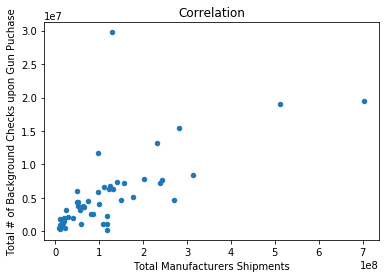

In [54]:
# Let's visualize scatter plot by pandas.plot
ax = result.plot.scatter(x='42', y='totals')
ax.set_title('Correlation')
ax.set_xlabel('Total Manufacturers Shipments')
ax.set_ylabel('Total # of Background Checks upon Gun Puchase')

Text(0, 0.5, 'Total # of Background Checks upon Gun Puchase')

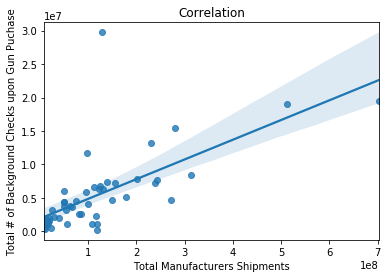

In [55]:
# Let's visualize it again by seaborn. It's even better, isn't it?
ax = sns.regplot(result['42'], result['totals'])
ax.set_title('Correlation')
ax.set_xlabel('Total Manufacturers Shipments')
ax.set_ylabel('Total # of Background Checks upon Gun Puchase')

### Visualizations on the correlation gives us a more concrete idea of how they are related.

<a id='question2'></a>
## Research Question 2:  Is there a strong correlation between ethnic group proportion and gun registration?

Let's take all the ethnic group related variables from the output of the previous question:

* 12 0.01166 White alone, percent, July 1, 2016,  (V2016)
* 13 0.14433 Black or African American alone, percent, July 1, 2016,  (V2016)
* 14 -0.22843 American Indian and Alaska Native alone, percent, July 1, 2016,  (V2016)
* 15 -0.02228 Asian alone, percent, July 1, 2016,  (V2016)
* 16 -0.15151 Native Hawaiian and Other Pacific Islander alone, percent, July 1, 2016,  (V2016)
* 17 -0.16064 Two or More Races, percent, July 1, 2016,  (V2016)
* 18 0.22636 Hispanic or Latino, percent, July 1, 2016,  (V2016)
* 19 -0.14671 White alone, not Hispanic or Latino, percent, July 1, 2016,  (V2016)

As you can see, all the correlations above are very week. Only Hispanic or Latino(18)'s correlation coefficient(0.22636) is a little bit higher than the other variables, but we cannot conclude anything from such a weak correlation.

<a id='question3'></a>
## Research Question 3: Is there a seasonal pattern for firearm shopping? 

#### Let's first group and sum all states' 'totals' column by 'month'

In [56]:
all_df_gun_totals = df_gun[['month','totals']]

In [57]:
all_df_gun_totals.set_index('month',inplace=True)

In [58]:
all_df_gun_totals=all_df_gun_totals[::-1]

In [59]:
gun_totals_groupby_month = all_df_gun_totals.groupby('month').sum()

In [60]:
gun_totals_groupby_month.head()

,totals
month,
1998-11,21176
1998-12,870722
1999-01,585974
1999-02,690215
1999-03,741687


### Let's start the exploration by visualizing the data in some plots

Text(0.5, 0, '# Background Checks')

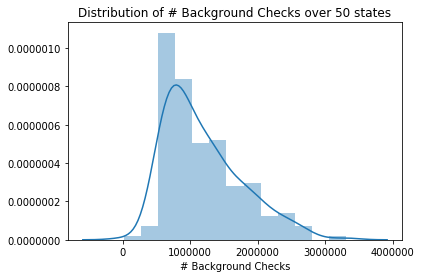

In [61]:
ax = sns.distplot(gun_totals_groupby_month)
ax.set_title('Distribution of # Background Checks over 50 states')
ax.set_xlabel('# Background Checks')

### Clearly, it's a slightly left-skewed distribution

Text(0.5, 0, '#Background Checks')

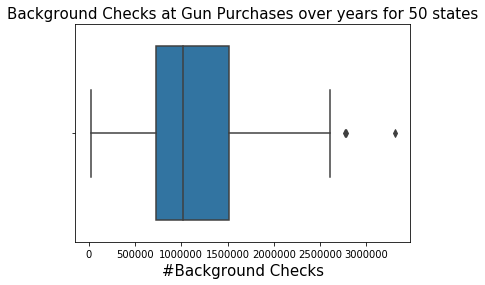

In [62]:
# Let's see what's the box
ax = sns.boxplot(gun_totals_groupby_month)
ax.set_title('Background Checks at Gun Purchases over years for 50 states', fontsize=15)
ax.set_xlabel('#Background Checks', fontsize=15)


### It seems we have a couple of outliers

### Let's see the line plot to detect if any patterns: 

Text(0, 0.5, '#Background Checks')

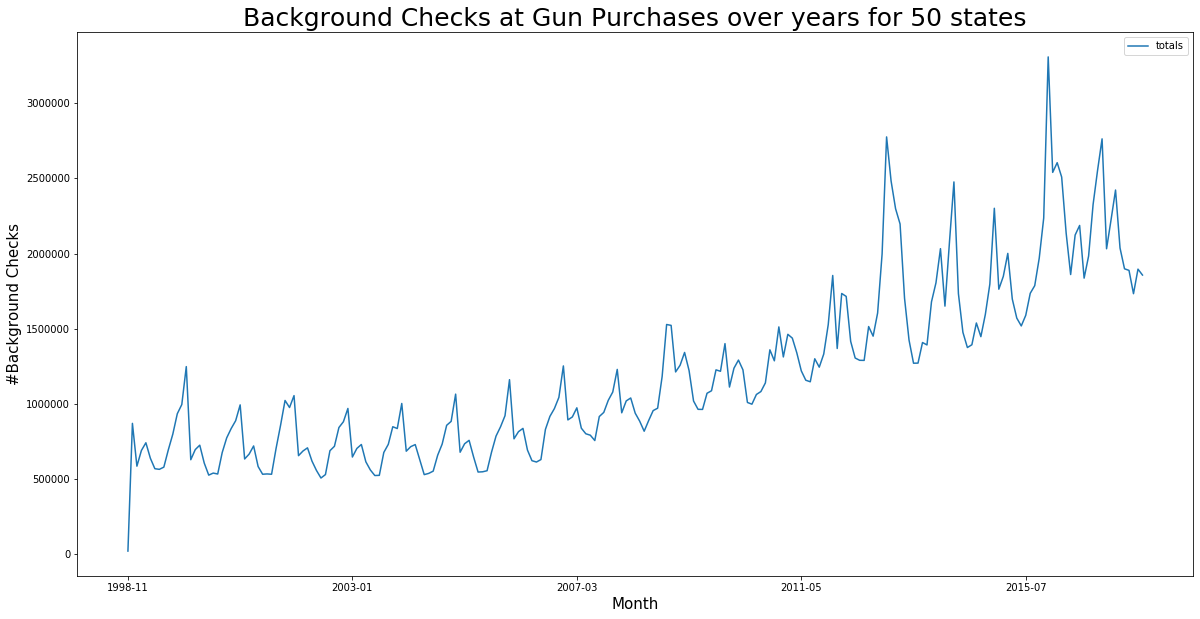

In [63]:
ax = gun_totals_groupby_month.plot(figsize=(20,10))
ax.set_title('Background Checks at Gun Purchases over years for 50 states', fontsize=25)
ax.set_xlabel('Month', fontsize=15)
ax.set_ylabel('#Background Checks', fontsize=15)
# not run yet

**Note**: We can see a sort of pattern here. But this is too broad to confirm a seasonal pattern. Let's take a look at the pattern closely in each year at the next step:

### Yearly Group Pattern graph
The two graphs below show the numbers changes in each year from Jan to Dec. 

As you can see from the above graph, from 2007, the number is going up, so the yearly graph will be divided into two graphs, one with year from 1999 to 2006, the other one with year from 2007 to 2016. The years 1998 and 2017 are excluded because their data are not complete(including less than 12 months）

[]

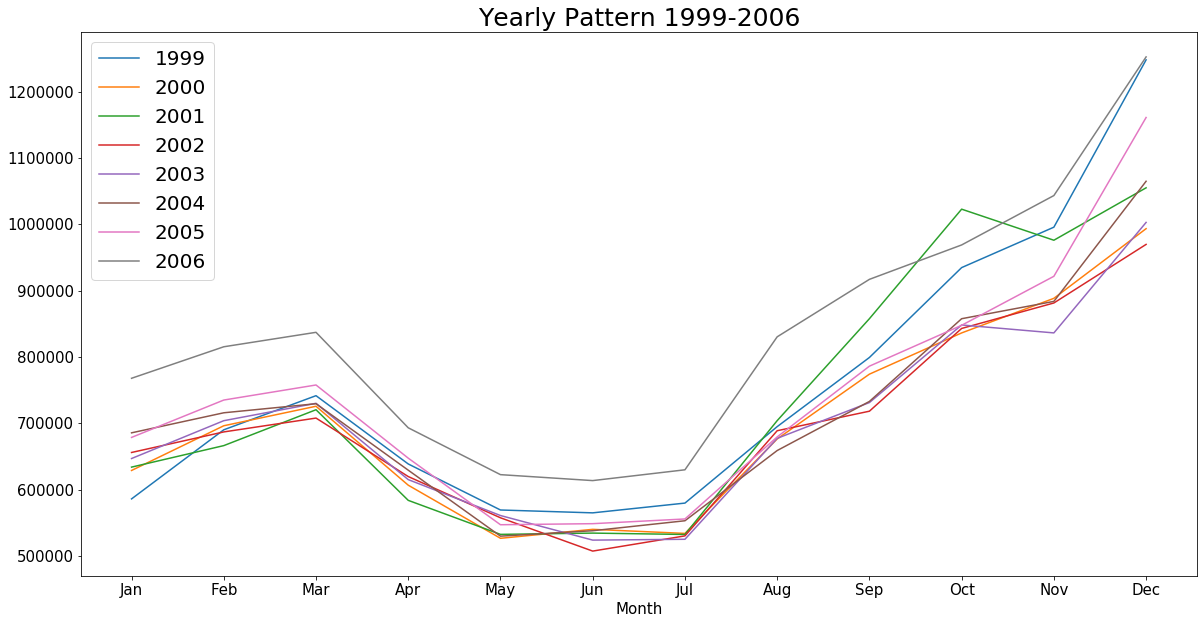

In [64]:
ax = gun_totals_groupby_month.loc['1999':'2000'].plot(figsize=(20,10),fontsize=15) #add the year 1999's plot first
legend =['1999']
for i in range(2000,2007): #excluding 1998 and 2017, for they are not complete
    ax = gun_totals_groupby_month.loc[str(i):str(i+1)].plot(ax=ax)
    legend.append(str(i))
ax.legend(legend,fontsize=20)
ax.set_xticks(np.arange(12))
ax.set_xticklabels(pd.Series(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']),fontdict={
     'fontsize': 15,
     'fontweight': 15})
ax.set_title('Yearly Pattern 1999-2006', fontsize=25)
ax.set_xlabel('Month', fontsize=15)
ax.plot()

[]

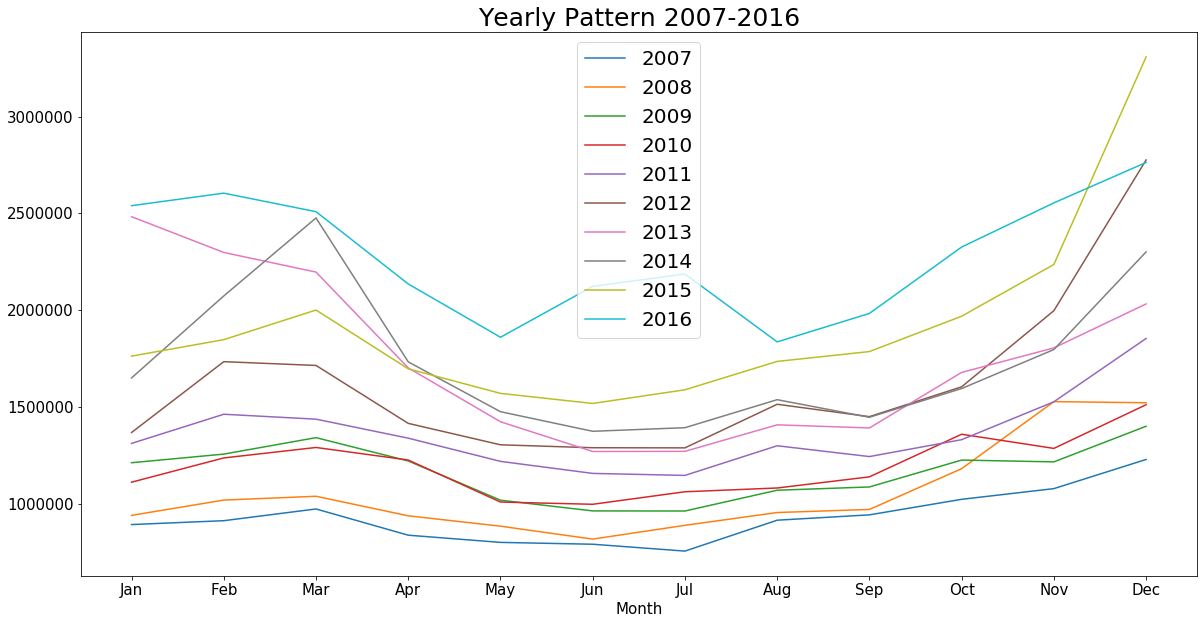

In [65]:
ax = gun_totals_groupby_month.loc['2007':'2008'].plot(figsize=(20,10),fontsize=15) #add the year 1999's plot first
legend =['2007']
for i in range(2008,2017): #excluding 1998 and 2017, for they are not complete
    ax = gun_totals_groupby_month.loc[str(i):str(i+1)].plot(ax=ax)
    legend.append(str(i))
ax.legend(legend,fontsize=20)
ax.set_xticks(np.arange(12))
ax.set_xticklabels(pd.Series(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']),fontdict={
     'fontsize': 15,
     'fontweight': 15})
ax.set_title('Yearly Pattern 2007-2016', fontsize=25)
ax.set_xlabel('Month', fontsize=15)
ax.plot()

As we can see from the plot from year 1999 to 2016, there is a significant pattern that the total number of background checks stays low during the summer and peaks at winter. So, the answer to this research question is: Yes, there's a seasonal pattern for background checks, and thus, for firearm shopping.

One thing worth noting is that, the number of 2016 has a little peak during the summer as opposed to other years, which worth some future research. A good question to ask is if there's a new regulation change on gun control.

<a id='conclusions'></a>
# Conclusions


With the exploration and statistical tests performed above, we can answer the questions raised at the begginning of this notebook, with limitation :
#### 1 - What census data is most associated with high gun registration?

> The most associated census data with gun data is 'Total Manufacturers Shipments' with a Pearson's Correlation Coefficient 0.67445. It doesn't seem to have any relation with gun registration number, however, that's the beauty of correlation. <b>It doesn't provide causation but provide a way to find a relation(correlation)</b>.

> The second and third most associated census data are the number of Veterans in each state(corr coef: 0.67324) and  the number of Households in each state(corr coef:0.65733). These two make more sense, <b>but still we cannot conclude their causation from the correlation.</b>

#### 2 - Is there a correlation between ethnic group proportion and gun registration?

> No. From the Pearson's Correlation Coefficient formula, the correlations are too weak.

#### 3 - Is there a seasonal pattern for firearm shopping? 

> Yes. From the year-to-year analysis from 1999 and 2016 of all the states, there's a clear pattern that the number stays low in the summer and peaks in the winter. There's a little inconsistency during the summer of 2016, which we need to research further into what happened before or during that summer.

<a id='limit'></a>
## Limitations
> #### Limitation 1:

> The dataset of census has a few inconsistant data, which are letters instead of numeric-like data and have some special meanings. 

>     For example:

In [67]:
# let's load the original census data:
df_census_temp = pd.read_csv('./ncis-and-census-data/U.S. Census Data.csv')
df_census_temp.iloc[42].head(15)

Fact           Total manufacturers shipments, 2012 ($1,000)
Fact Note                                               (c)
Alabama                                         124,809,759
Alaska                                                    D
Arizona                                          51,243,473
Arkansas                                         62,712,925
California                                      512,303,164
Colorado                                         50,447,098
Connecticut                                      55,160,095
Delaware                                         22,597,384
Florida                                          96,924,106
Georgia                                         155,836,792
Hawaii                                                    D
Idaho                                            20,201,432
Illinois                                        281,037,755
Name: 42, dtype: object

#### For the states of Alaska and Hawaii, the data points are 'D', which means 'Suppressed to avoid disclosure of confidential information!'. This information is provided at the end of the original csv data table.

#### In Research Questions1, we changed this kind of information into NaN, and fill them with the mean of that row.

> #### Limitation 2:

> Correlation doesn't imply causation. We investigate a lot of correlation Research Question1. We found the most associated census data with gun data. But we cannot conclude that the number of Total manufacturers shipments increases causes the gun sale. We need to be very careful about this. 